In [1]:
welllog_head = ['DEPT', 'RMG', 'RMN', 'RMN-RMG', 'CAL', 'SP', 'GR', 'HAC', 'BHC', 'DEN']
well_num = 6
data_prefix = 'data/vertical_all_A{}.csv'
test_ID = [6, ]
columns_target = ['HAC', 'BHC', 'DEN']
columns_input = ['DEPT', 'RMN-RMG', 'CAL', 'SP', 'GR']
train_len = 200
window_step = 100


In [2]:
import pandas as pd

def read_file(path):
    df = pd.read_csv(path)
    df.columns = welllog_head
    return df

In [3]:
import numpy as np

df_well_list = []
test_data = {}
for i in range(well_num):
    # the test and train data will be the unnormalized data
    filename = data_prefix.format(i+1)
    df = read_file(filename)
    df['DEPT'] = np.arange(1, len(df)+1)
    df_well_list.append(df)
    if i+1 in test_ID:
        test_data[i+1] = df[columns_target]
dataset = pd.concat(df_well_list, axis=0, ignore_index=True)

In [4]:
len(df_well_list)

6

In [5]:
dataset

,DEPT,RMG,RMN,RMN-RMG,CAL,SP,GR,HAC,BHC,DEN
0,1,2.260,2.265,0.005,23.492,121.845,102.405,402.244,405.716,2.269
1,2,2.241,2.281,0.040,23.453,121.845,103.093,397.115,404.701,2.274
2,3,2.405,2.474,0.069,23.403,121.656,102.995,394.872,403.953,2.284
3,4,2.598,2.640,0.042,23.363,121.325,102.405,397.009,404.434,2.274
4,5,2.533,2.538,0.005,23.333,120.994,101.128,404.060,405.021,2.284
...,...,...,...,...,...,...,...,...,...,...
38729,5790,6.191,8.237,2.046,21.125,66.313,81.215,335.470,336.003,2.116
38730,5791,5.867,8.042,2.175,21.095,66.248,82.754,335.470,333.760,2.144
38731,5792,6.723,9.164,2.441,21.080,66.150,84.678,335.150,331.571,2.164
38732,5793,7.263,9.530,2.267,21.118,66.248,87.660,335.150,329.755,2.178


将df_well_all数据整理成窗口序列数据，使用npy或者h5文件存储，方便后续读取。

In [14]:
# data 先要进行标准化转换
# eg:X = StandardScaler().fit_transform(X.to_numpy())
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = columns_input + columns_target
scaler.fit(dataset[columns_to_scale])
dataset[columns_to_scale] = scaler.transform(dataset[columns_to_scale])
dataset

,DEPT,RMG,RMN,RMN-RMG,CAL,SP,GR,HAC,BHC,DEN
0,-1.716107,2.260,2.265,-0.687548,1.382265,1.389699,-0.076729,1.203110,1.354331,0.021540
1,-1.715578,2.241,2.281,-0.658715,1.345440,1.389699,-0.067284,1.092743,1.331241,0.073887
2,-1.715048,2.405,2.474,-0.634824,1.298230,1.378332,-0.068630,1.044477,1.314226,0.178583
3,-1.714519,2.598,2.640,-0.657067,1.260461,1.358426,-0.076729,1.090462,1.325168,0.073887
4,-1.713990,2.533,2.538,-0.687548,1.232135,1.338520,-0.094258,1.242187,1.338521,0.178583
...,...,...,...,...,...,...,...,...,...,...
38729,1.347992,6.191,8.237,0.993849,-0.852690,-1.949959,-0.367605,-0.233752,-0.231540,-1.580308
38730,1.348522,5.867,8.042,1.100121,-0.881016,-1.953868,-0.346479,-0.233752,-0.282565,-1.287160
38731,1.349051,6.723,9.164,1.319255,-0.895179,-1.959762,-0.320068,-0.240638,-0.332362,-1.077768
38732,1.349580,7.263,9.530,1.175912,-0.859299,-1.953868,-0.279134,-0.240638,-0.373673,-0.931194


In [15]:
import pandas as pd
from tsai.basics import *

data = dataset

# 设置滑动窗口长度和预测的距离
window_len = 200
horizon = 100

# 设置输入特征和目标变量的列名
x_vars = ['DEPT', 'RMN-RMG', 'CAL', 'SP', 'GR', 'HAC', 'BHC', 'DEN']

# 将列名转换为整数索引
x_vars_idx = [data.columns.get_loc(col) for col in x_vars]

# 调用apply_sliding_window函数接口
X, y = apply_sliding_window(data, window_len, horizon, x_vars_idx)

# 输出结果
print("X shape:", X.shape)

X shape: (38435, 8, 200)


输出X的内容，分析窗口的划分方式是否合理。

In [8]:
print("显示X的内容：")
print("-" * 50)
display(X)
print("\n显示X的形状：")
print("-" * 50)
display(X.shape)
print("\n显示X的类型：")
print("-" * 50)
display(type(X))
print("\n显示X的第一个元素：")
print("-" * 50)
display(X[0])
print("\n显示X的第一个元素的形状：")
print("-" * 50)
display(X[0].shape)
print("\n显示X的第一个元素的第一个元素：")
print("-" * 50)
display(X[0][0])
print("\n显示X的第一个元素的第一个元素的形状：")
print("-" * 50)
display(X[0][0].shape)
print("\n显示X的第一个元素的第一个元素的类型：")
print("-" * 50)
display(type(X[0][0]))

显示X的内容：
--------------------------------------------------


array([[[ 1.00000e+00,  2.00000e+00,  3.00000e+00, ...,  1.98000e+02,
          1.99000e+02,  2.00000e+02],
        [ 5.00000e-03,  4.00000e-02,  6.90000e-02, ..., -3.43000e-01,
          9.00000e-02,  2.11000e-01],
        [ 2.34920e+01,  2.34530e+01,  2.34030e+01, ...,  2.30060e+01,
          2.30260e+01,  2.30620e+01],
        ...,
        [ 4.02244e+02,  3.97115e+02,  3.94872e+02, ...,  4.14637e+02,
          4.11538e+02,  4.08227e+02],
        [ 4.05716e+02,  4.04701e+02,  4.03953e+02, ...,  4.08707e+02,
          4.06944e+02,  4.06517e+02],
        [ 2.26900e+00,  2.27400e+00,  2.28400e+00, ...,  2.11800e+00,
          2.11900e+00,  2.12100e+00]],

       [[ 2.00000e+00,  3.00000e+00,  4.00000e+00, ...,  1.99000e+02,
          2.00000e+02,  2.01000e+02],
        [ 4.00000e-02,  6.90000e-02,  4.20000e-02, ...,  9.00000e-02,
          2.11000e-01,  6.10000e-02],
        [ 2.34530e+01,  2.34030e+01,  2.33630e+01, ...,  2.30260e+01,
          2.30620e+01,  2.30930e+01],
        ...,



显示X的形状：
--------------------------------------------------


(38435, 8, 200)


显示X的类型：
--------------------------------------------------


numpy.ndarray


显示X的第一个元素：
--------------------------------------------------


array([[ 1.00000e+00,  2.00000e+00,  3.00000e+00, ...,  1.98000e+02,
         1.99000e+02,  2.00000e+02],
       [ 5.00000e-03,  4.00000e-02,  6.90000e-02, ..., -3.43000e-01,
         9.00000e-02,  2.11000e-01],
       [ 2.34920e+01,  2.34530e+01,  2.34030e+01, ...,  2.30060e+01,
         2.30260e+01,  2.30620e+01],
       ...,
       [ 4.02244e+02,  3.97115e+02,  3.94872e+02, ...,  4.14637e+02,
         4.11538e+02,  4.08227e+02],
       [ 4.05716e+02,  4.04701e+02,  4.03953e+02, ...,  4.08707e+02,
         4.06944e+02,  4.06517e+02],
       [ 2.26900e+00,  2.27400e+00,  2.28400e+00, ...,  2.11800e+00,
         2.11900e+00,  2.12100e+00]])


显示X的第一个元素的形状：
--------------------------------------------------


(8, 200)


显示X的第一个元素的第一个元素：
--------------------------------------------------


array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15


显示X的第一个元素的第一个元素的形状：
--------------------------------------------------


(200,)


显示X的第一个元素的第一个元素的类型：
--------------------------------------------------


numpy.ndarray

存储起来作为SAITS的模型的数据输入。

In [16]:
import numpy as np

# 假设X是你的numpy.ndarray
# 保存数据到文件
np.save('data_input.npy', X)

In [17]:
import numpy as np

# 加载数据
X = np.load('data_input.npy')

In [10]:
import pandas as pd

# 假设df是你的DataFrame
# 保存数据到Pickle文件
X.to_pickle('./data/data_input.pkl')

AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'

In [22]:
import pandas as pd
from tsai.basics import *

data = dataset

# 设置滑动窗口长度和预测的距离
window_len = 200
horizon = 100

# 设置输入特征和目标变量的列名
x_vars = ['DEPT', 'RMN-RMG', 'CAL', 'SP', 'GR']
y_vars = ['HAC', 'BHC', 'DEN']

# 将列名转换为整数索引
x_vars_idx = [data.columns.get_loc(col) for col in x_vars]
y_vars_idx = [data.columns.get_loc(col) for col in y_vars]

# 调用apply_sliding_window函数接口
X, y = apply_sliding_window(data, window_len, horizon, x_vars_idx, y_vars_idx)

# 输出结果
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (38435, 5, 200)
y shape: (38435, 3)


In [23]:
import numpy as np
import pandas as pd
from tsai.data.preparation import apply_sliding_window

# 创建一个模拟数据集
np.random.seed(42)
data = pd.DataFrame(np.random.rand(1000, 5), columns=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Target'])

# 设置滑动窗口长度和预测的距离
window_len = 5
horizon = 1

# 设置输入特征和目标变量的列名
x_vars = ['Feature1', 'Feature2', 'Feature3', 'Feature4']
y_vars = ['Target']

# 将列名转换为整数索引
x_vars_idx = [data.columns.get_loc(col) for col in x_vars]
y_vars_idx = [data.columns.get_loc(col) for col in y_vars]

# 调用apply_sliding_window函数接口
X, y = apply_sliding_window(data, window_len, horizon, x_vars_idx, y_vars_idx)

# 输出结果
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (995, 4, 5)
y shape: (995,)


## 案例一：前面窗口为x，后面窗口为y



In [25]:
data = np.arange(10).reshape(-1,1).repeat(3, 1) * np.array([1, 10, 100])
df = pd.DataFrame(data, columns=['feat_1', 'feat_2', 'feat_3'])
df

,feat_1,feat_2,feat_3
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


In [30]:
window_len = 6
horizon = 1
x_vars = None
y_vars = None
X, y = apply_sliding_window(data, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, data))
print(np.shares_memory(y, data))
print(X.shape, y.shape)
test_eq(X.shape, (len(df) - (window_len - 1 + horizon), df.shape[1], window_len))
test_eq(y.shape, (len(df) - (window_len - 1 + horizon), df.shape[1]))
X[0], y[0]

True
True
(4, 3, 6) (4, 3)


(array([[  0,   1,   2,   3,   4,   5],
        [  0,  10,  20,  30,  40,  50],
        [  0, 100, 200, 300, 400, 500]]),
 array([  6,  60, 600]))

In [31]:
X

array([[[  0,   1,   2,   3,   4,   5],
        [  0,  10,  20,  30,  40,  50],
        [  0, 100, 200, 300, 400, 500]],

       [[  1,   2,   3,   4,   5,   6],
        [ 10,  20,  30,  40,  50,  60],
        [100, 200, 300, 400, 500, 600]],

       [[  2,   3,   4,   5,   6,   7],
        [ 20,  30,  40,  50,  60,  70],
        [200, 300, 400, 500, 600, 700]],

       [[  3,   4,   5,   6,   7,   8],
        [ 30,  40,  50,  60,  70,  80],
        [300, 400, 500, 600, 700, 800]]])

In [33]:
for i in range(len(X)):
    print(X[i].shape, y[i].shape)
    print(X[i], y[i])

(3, 6) (3,)
[[  0   1   2   3   4   5]
 [  0  10  20  30  40  50]
 [  0 100 200 300 400 500]] [  6  60 600]
(3, 6) (3,)
[[  1   2   3   4   5   6]
 [ 10  20  30  40  50  60]
 [100 200 300 400 500 600]] [  7  70 700]
(3, 6) (3,)
[[  2   3   4   5   6   7]
 [ 20  30  40  50  60  70]
 [200 300 400 500 600 700]] [  8  80 800]
(3, 6) (3,)
[[  3   4   5   6   7   8]
 [ 30  40  50  60  70  80]
 [300 400 500 600 700 800]] [  9  90 900]


## 案例二

In [34]:
window_len = 6
horizon = 1
x_vars = None
y_vars = 0
X, y = apply_sliding_window(df, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, df))
print(np.shares_memory(y, df))
print(X.shape, y.shape)
test_eq(X.shape, (len(df) - (window_len - 1 + horizon), df.shape[1], window_len))
test_eq(y.shape, (len(df) - (window_len - 1 + horizon),))
X[0], y[0]

True
True
(4, 3, 6) (4,)


(array([[  0,   1,   2,   3,   4,   5],
        [  0,  10,  20,  30,  40,  50],
        [  0, 100, 200, 300, 400, 500]]),
 6)

## 案例三

In [36]:
window_len = 8
horizon = [1, 2]
x_vars = 0
y_vars = [1, 2]
X, y = apply_sliding_window(df, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, df))
print(np.shares_memory(y, df))
print(X.shape, y.shape)

X[0], y[0]

True
False
(1, 1, 8) (2, 2)


(array([[0, 1, 2, 3, 4, 5, 6, 7]]), array([80, 90]))

## 案例四

In [38]:
window_len = [-4, -2, -1, 0]
horizon = [1, 2, 4]
x_vars = 0
y_vars = [1, 2]
X, y = apply_sliding_window(df, window_len, horizon=horizon, x_vars=x_vars, y_vars=y_vars)
print(np.shares_memory(X, df))
print(np.shares_memory(y, df))
print(X.shape, y.shape)
X[0], y[0]

False
False
(2, 1, 4) (2, 2, 3)


(array([[0, 2, 3, 4]]),
 array([[ 50,  60,  80],
        [500, 600, 800]]))

## slidingWindow

In [40]:
t

array([[ 0,  0,  0],
       [ 1,  1,  1],
       [ 2,  2,  2],
       [ 3,  3,  3],
       [ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       [ 7,  7,  7],
       [ 8,  8,  8],
       [ 9,  9,  9],
       [10, 10, 10],
       [11, 11, 11],
       [12, 12, 12]])

### 案例一

In [58]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X

input shape: (13, 3)


array([[[ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [ 0.,  0.,  0.,  1.,  1.]]])

In [59]:
X.shape

(3, 4, 5)

In [60]:
X[0]

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 0., 0., 0., 0.]])

In [61]:
X[0].shape

(4, 5)

In [62]:
X[:0:]

array([], shape=(0, 4, 5), dtype=float64)

In [64]:
display(y)

None

### 案例二

In [65]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [66]:
X

array([[[0, 1, 2, 3, 4]],

       [[1, 2, 3, 4, 5]],

       [[2, 3, 4, 5, 6]],

       [[3, 4, 5, 6, 7]],

       [[4, 5, 6, 7, 8]]])

In [67]:
display(y)

array([5, 6, 7, 8, 9])

### 案例三

In [78]:
wl = 5
h = 2

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=2, horizon=h)(t)
items = itemify(X, y)
print(items)


input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[2, 3, 4, 5, 6]]), array([7, 8]))]


In [79]:
X

array([[[0, 1, 2, 3, 4]],

       [[2, 3, 4, 5, 6]]])

In [80]:
y


array([[5, 6],
       [7, 8]])

### 案例三

In [81]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


## 案例四

In [84]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [85]:
display(X.shape)
display(y.shape)

(4, 1, 5)

(4, 2)

### 案例五

In [88]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [89]:
display(X.shape)
display(y.shape)

(4, 1, 5)

(4, 2)

### 案例六

In [90]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [91]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [92]:
display(t.shape)
display(X.shape)
display(y.shape)

(20,)

(3, 1, 5)

(3,)

In [93]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [94]:
display(t.shape)
display(X.shape)
display(y.shape)

(20,)

(3, 1, 5)

(3,)

In [95]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [96]:
display(t.shape)
display(X.shape)
display(y.shape)

(20,)

(15, 1, 5)

(15,)

In [97]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [98]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [99]:
display(t.shape)
display(X.shape)
display(y.shape)

torch.Size([10, 3])

(5, 3, 5)

(5, 3)

In [103]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y="var_0")(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [104]:
display(t.shape)
display(X.shape)
display(y.shape)

torch.Size([10, 3])

(5, 3, 5)

(5,)

In [107]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


In [102]:
display(t.shape)
display(X.shape)
display(y.shape)

torch.Size([10, 3])

(5, 2, 5)

(5,)

(1000, 3)


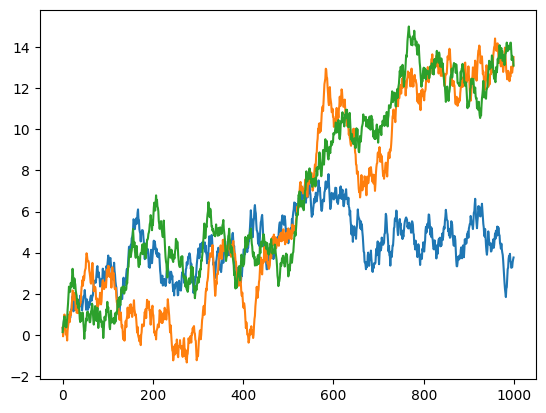

(200, 2, 5) (200,)


In [123]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [124]:
display(X[0], y[0])

array([[ 0.33145323,  0.18398109,  0.41050728,  0.73920222,  0.66616862],
       [ 0.34961119, -0.07357779,  0.33902474,  0.58497935,  0.98709666]])

0.8979557011062506

In [118]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,-0.084518,0.131014,-0.114145
1,-0.244839,0.265494,-0.023083
2,-0.451312,-0.085157,-0.154506
3,-0.536114,0.043527,0.260023
4,-0.999929,-0.212812,-0.046261
...,...,...,...
95,1.607545,-1.377046,-0.552172
96,1.150890,-1.512620,-0.672263
97,1.456161,-1.359489,-0.735540
98,1.608275,-1.806706,-1.055268


(96, 2, 5) (96,)


In [119]:
display(X[0], y[0])

array([[-0.08451791, -0.24483948, -0.45131152, -0.53611388, -0.99992908],
       [ 0.13101419,  0.26549427, -0.08515728,  0.04352705, -0.21281194]])

-0.04626114547471294

In [120]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.097000,0.222554,0.183980,0.463393,-0.284870
1,-0.045321,0.324319,0.682628,0.164578,-0.261652
2,-0.199135,0.350212,0.414757,-0.287810,-0.189086
3,-0.363281,0.032153,0.238692,-0.738530,0.261356
4,-0.282133,0.346922,0.161811,-0.335215,0.244674
...,...,...,...,...,...
95,3.989339,-2.548635,0.059998,4.822816,2.699057
96,3.947053,-2.405811,-0.336965,5.227280,2.767661
97,4.227391,-2.111370,-0.580484,5.256455,3.228141
98,3.817026,-1.928320,-0.118220,5.057032,3.589589


(96, 4, 5) (96,)


In [121]:
display(X[0], y[0])

array([[-0.09700024, -0.04532068, -0.19913537, -0.36328105, -0.28213314],
       [ 0.2225541 ,  0.32431854,  0.35021151,  0.03215291,  0.34692159],
       [ 0.18398033,  0.68262822,  0.41475682,  0.23869239,  0.16181058],
       [ 0.46339338,  0.16457752, -0.2878101 , -0.7385299 , -0.33521523]])

0.2446741559320169

In [114]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.006025,-0.394052,-0.780592,-0.600916,-1.032390,-1.259077,-1.028315,-0.962783,-0.886323,-0.797122,...,-1.471717,-0.975475,-1.036283,-0.754089,-0.872561,-1.200926,-1.409273,-1.262498,-1.442136,-1.616492
var_1,-0.223589,-0.582540,-1.029123,-0.816164,-0.448170,-0.650450,-0.851370,-0.449785,-0.015891,0.206033,...,-0.281154,-0.044596,0.242200,0.698012,0.932667,0.644626,0.936158,1.428945,1.124729,0.860976
var_2,0.068728,0.389807,0.498104,0.933446,1.226034,1.286777,1.239151,1.234623,1.057711,1.331230,...,4.732380,4.319830,4.743306,4.823537,5.251308,5.283343,5.591453,5.714044,6.027095,6.435478
var_3,-0.048363,0.337519,0.552873,0.117746,0.192388,-0.049568,-0.421901,0.019525,-0.114833,-0.465017,...,-2.084060,-2.563810,-2.464510,-2.282513,-2.153524,-2.476970,-2.513182,-2.977408,-2.632602,-2.629953
target,-0.065041,-0.330357,-0.457547,-0.765256,-1.181592,-1.608632,-1.306084,-0.914216,-1.368738,-1.424579,...,-0.019222,0.200066,-0.112826,-0.275351,0.014497,0.149492,-0.169698,-0.652404,-0.893785,-0.737648


(96, 4, 5) (96,)


df 与 seq_first 这两部分连用，因为，df要是二维的深度序列向下排列（或者是时间序列）的话，那么直接seq_first = true就可以了。

如果进行了转置，那么就要用seq_first = false。表示第一维度不是序列的维度。

这种维度，第一维度，第二维度，第三维度，具体代码的信息，以及在矩阵中涉及到的相关矩阵的转置的内容。（包括输入到模型中的数据格式维度，torch深度学习模型中的相关维度。）

In [115]:
display(X[0], y[0])

array([[-0.00602501, -0.39405204, -0.78059154, -0.60091567, -1.03238968],
       [-0.22358946, -0.58253977, -1.0291231 , -0.81616428, -0.44817035],
       [ 0.06872794,  0.38980652,  0.49810413,  0.93344641,  1.22603357],
       [-0.04836332,  0.33751942,  0.55287263,  0.11774627,  0.19238834]])

-1.1815922382780646

In [116]:
display(X[0], X[1])

array([[-0.00602501, -0.39405204, -0.78059154, -0.60091567, -1.03238968],
       [-0.22358946, -0.58253977, -1.0291231 , -0.81616428, -0.44817035],
       [ 0.06872794,  0.38980652,  0.49810413,  0.93344641,  1.22603357],
       [-0.04836332,  0.33751942,  0.55287263,  0.11774627,  0.19238834]])

array([[-0.39405204, -0.78059154, -0.60091567, -1.03238968, -1.25907733],
       [-0.58253977, -1.0291231 , -0.81616428, -0.44817035, -0.6504505 ],
       [ 0.38980652,  0.49810413,  0.93344641,  1.22603357,  1.28677677],
       [ 0.33751942,  0.55287263,  0.11774627,  0.19238834, -0.04956776]])

In [112]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.489548,0.065637,0.559027,0.897203,1.179939,1.233331,0.790974,1.125712,1.331619,1.665428,...,-0.186662,0.150241,-0.242748,-0.561667,-0.690548,-0.542888,-0.943936,-1.007448,-0.708835,-0.998373
var_1,-0.021167,0.082435,0.281162,-0.197199,0.048951,0.193240,0.630502,0.163635,0.057299,-0.047661,...,3.026109,3.191157,2.983753,3.115735,2.712425,3.129248,3.311890,3.062436,3.020985,2.886999
var_2,-0.271680,0.159545,-0.178174,-0.445027,-0.894426,-1.225797,-1.139529,-1.371151,-1.598483,-1.534265,...,-0.852968,-1.086165,-1.034375,-0.918585,-1.192124,-1.049382,-1.296546,-1.462100,-1.762279,-1.381931
var_3,-0.118142,0.232220,-0.255363,0.001942,0.394454,0.870685,1.069878,1.039526,0.542905,0.270592,...,0.553422,0.170463,-0.265537,-0.214771,0.182934,-0.283869,-0.391888,-0.550340,-0.239324,-0.607537
target,0.153838,-0.278488,-0.607205,-0.521095,-0.794063,-0.805907,-0.780731,-1.204128,-0.984297,-0.862100,...,-1.667243,-2.151185,-2.514957,-2.764455,-2.284764,-1.788001,-1.642067,-1.182743,-1.525560,-1.903326


(20, 4, 5) (20,)


In [113]:
display(X[0], y[0])

array([[ 0.48954812,  0.06563749,  0.55902737,  0.89720329,  1.179939  ],
       [-0.02116718,  0.08243474,  0.28116166, -0.19719902,  0.04895149],
       [-0.27167983,  0.15954493, -0.17817424, -0.44502694, -0.89442555],
       [-0.11814237,  0.23222041, -0.2553635 ,  0.0019421 ,  0.39445352]])

-0.7940630670528352

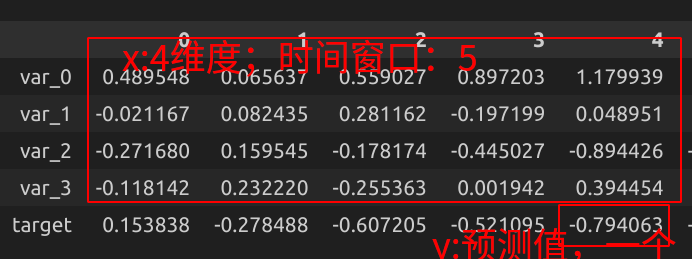

In [117]:
display(X[0], X[1])

array([[-0.00602501, -0.39405204, -0.78059154, -0.60091567, -1.03238968],
       [-0.22358946, -0.58253977, -1.0291231 , -0.81616428, -0.44817035],
       [ 0.06872794,  0.38980652,  0.49810413,  0.93344641,  1.22603357],
       [-0.04836332,  0.33751942,  0.55287263,  0.11774627,  0.19238834]])

array([[-0.39405204, -0.78059154, -0.60091567, -1.03238968, -1.25907733],
       [-0.58253977, -1.0291231 , -0.81616428, -0.44817035, -0.6504505 ],
       [ 0.38980652,  0.49810413,  0.93344641,  1.22603357,  1.28677677],
       [ 0.33751942,  0.55287263,  0.11774627,  0.19238834, -0.04956776]])

In [125]:
from tsai.data.validation import TrainValidTestSplitter

In [126]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.405772,-0.446544,-0.191611,-0.211855,0.126365
1,0.036997,-0.064197,0.136941,-0.059789,0.084779
2,0.469953,0.266550,0.136256,0.142084,0.151709
3,0.557895,0.097526,0.098340,-0.279794,0.009058
4,0.753724,0.550742,0.561404,-0.224071,0.115680
...,...,...,...,...,...
95,-1.282781,-1.828456,-0.715765,4.368933,0.664703
96,-0.958677,-2.103724,-0.879635,4.092659,0.616876
97,-0.573613,-2.258517,-1.005168,4.453026,0.632251
98,-0.538164,-1.897716,-1.014641,4.634583,0.217895


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [127]:
data = np.concatenate([np.linspace(0, 1, 11).reshape(-1,1).repeat(2, 1), np.arange(11).reshape(-1,1)], -1)
df_test = pd.DataFrame(data, columns=['col1', 'col2', 'target'])
df_test['target'] = df_test['target'].astype(int)
df_test

,col1,col2,target
0,0.0,0.0,0
1,0.1,0.1,1
2,0.2,0.2,2
3,0.3,0.3,3
4,0.4,0.4,4
5,0.5,0.5,5
6,0.6,0.6,6
7,0.7,0.7,7
8,0.8,0.8,8
9,0.9,0.9,9


In [128]:
def _y_func(o): return o[:, 0]

In [129]:
import numpy as np

# 创建一个二维数组
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 使用_y_func函数提取第一列
first_column = _y_func(data)

print(first_column)

[1 4 7]


In [130]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=_y_func)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[2], wl)
    test_close(x[:, 0, 0]*10, y)

In [133]:
df = pd.DataFrame()
df['sample_id'] = np.concatenate([np.ones(n)*(i + 1) for i,n in enumerate([13])])
df['var1'] = df['sample_id'] + df.index.values - 1
df['var2'] = df['var1'] * 10
df['target'] = (df['var1']).astype(int)
df['sample_id'] = df['sample_id'].astype(int)
df

,sample_id,var1,var2,target
0,1,0.0,0.0,0
1,1,1.0,10.0,1
2,1,2.0,20.0,2
3,1,3.0,30.0,3
4,1,4.0,40.0,4
5,1,5.0,50.0,5
6,1,6.0,60.0,6
7,1,7.0,70.0,7
8,1,8.0,80.0,8
9,1,9.0,90.0,9


- sample_id列：这是一个标识每个样本的唯一标识符。在这个例子中，所有的样本都被标记为1，这可能意味着这些样本都属于同一类别或者是同一组的一部分
- target列：这是一个整数序列，从0开始，每一行增加1。这可能是一个标签列，表示每个样本的类别或者目标值。在这个例子中，它看起来像是一个简单的整数序列，可能用于分类或者回归任务的目标变量。

In [134]:
X, y = SlidingWindow(window_len=3, stride=2, start=3, pad_remainder=False, padding="pre", padding_value=np.nan, add_padding_feature=False,
                     get_x=["var1", "var2"], get_y=["target"], y_func=None, output_processor=None, copy=False, horizon=4, seq_first=True, sort_by=None,
                     ascending=True, check_leakage=True)(df)
test_eq(X.shape, (2, 2, 3))
test_eq(y.shape, (2, 4))
X, y

(array([[[ 4.,  5.,  6.],
         [40., 50., 60.]],
 
        [[ 6.,  7.,  8.],
         [60., 70., 80.]]]),
 array([[ 7,  8,  9, 10],
        [ 9, 10, 11, 12]]))

1. **滑动窗口参数设置**：
   - `window_len=3`：每个窗口的长度为3，意味着每个窗口包含3个连续的数据点。
   - `stride=2`：窗口移动的步长为2，也就是说，每次移动2个数据点。
   - `start=3`：窗口的起始位置为3，意味着第一个窗口的第一个数据点是原始数据的第4个数据点。
   - `pad_remainder=False`：如果数据长度不能被窗口长度和步长整除，不进行填充。
   - `padding="pre"`：在窗口的前面进行填充。
   - `padding_value=np.nan`：填充的值为`NaN`。
   - `add_padding_feature=False`：不添加额外的特征来表示是否填充。
   - `get_x=["var1", "var2"]`：选择`var1`和`var2`作为输入特征。
   - `get_y=["target"]`：选择`target`作为目标变量。
   - `horizon=4`：预测的未来步长为4，意味着每个窗口的目标变量是窗口后面的4个数据点。

2. **处理结果**：
   - 输入特征`X`是一个三维数组，形状为`(2, 2, 3)`。这意味着有2个窗口，每个窗口包含2个特征序列（`var1`和`var2`），每个序列有3个数据点。
   - 目标变量`y`是一个二维数组，形状为`(2, 4)`。这意味着有2个窗口，每个窗口的目标变量是窗口后面的4个数据点。

通过这种处理方式，原始数据被转换为了一个可以用于训练机器学习模型的格式，其中`X`是输入特征，`y`是对应的目标变量。这种处理方式常用于时间序列预测、分类等任务，它允许模型学习如何根据过去的数据预测未来的数据。

In [136]:
df

,sample_id,var1,var2,target
0,1,0.0,0.0,0
1,1,1.0,10.0,1
2,1,2.0,20.0,2
3,1,3.0,30.0,3
4,1,4.0,40.0,4
5,1,5.0,50.0,5
6,1,6.0,60.0,6
7,1,7.0,70.0,7
8,1,8.0,80.0,8
9,1,9.0,90.0,9


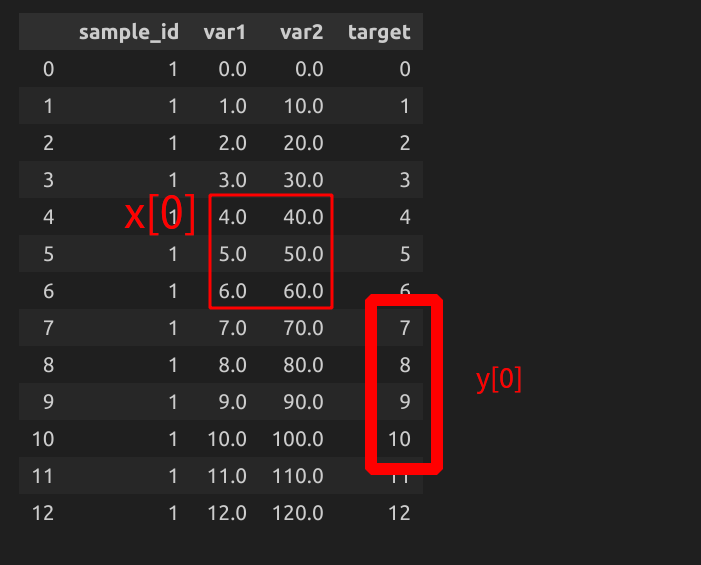

In [137]:
display(X.shape,y.shape)
display(X[0],y[0])
display(X[0],X[1])

(2, 2, 3)

(2, 4)

array([[ 4.,  5.,  6.],
       [40., 50., 60.]])

array([ 7,  8,  9, 10])

array([[ 4.,  5.,  6.],
       [40., 50., 60.]])

array([[ 6.,  7.,  8.],
       [60., 70., 80.]])